In [1]:
# library preparations
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import joblib
import seaborn as sns
import time
import os

# export PATH=/usr/local/texlive/2021/bin/x86_64-linux/xelatex:$PATH
# jupyter nbconvert RandomForest.ipynb --to pdf
print(os.environ['PATH'])

/home/samsoup/anaconda3/bin:/home/samsoup/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


# Model Fitting

Given that we could just ask the simulation for more samples, I decided to NOT employ a typical training-split. Ratther, I will deploy all samples for training and optimize based on cross validation approaches, given every test record a turn at being in the training set and test set. Once the model is fitted, we can then ask the simulation for some more samples (say 1000) to use as a test set completely related here.

## Model Evaluations

Many metrics can be used to evaluate models, some I calculate here are:

1. Accuracy: TP + TN / total, this is the number of samples the RF model classifiers correctly
2. Error Rate: 1 - Accuracy, this is the number of samples the RF model classifiers incorrectly
3. True Positive Rate (TPR) | Sensitivity | Recall | Coverage: TP / (TP + FN), fraction of SAS examples correctly predicted
    + There's a typically a trade off between Recall and Precision below
4. True Negative Rate (TNR) | Specificity: TN / (FP + TN), fraction of neutral examples correctly predicted
5. False Positive Rate (FPR): FP / (FP + TN) fraction of neutral examples predicted as having SAS (really bad)
6. False Negative Rate (FNR): FN / (TP + FN) fraction of SAS examples predicted as having SAS (not as bad, but still bad)
7. Precision: TP / (TP + FP), fraction of samples that actually have SAS out of total samples predicted to have SAS
    + Precision addresses the question: "Given a sample predicted to have SAS, how likely is it to be correct?"
    + **We may want to sacrifice Recall in order to archieve a high precision**
8. F-measure: $\frac{2*precision*recall}{precision+recall}$, a harmonic mean (meaning the resulting metric is *closer to the smaller of the input, that is, F-measure is closer to either precision or recall, whichever is smaller in magnitude) of precision and recall
    + **Ideally, a F-measure should be high and indicate that both precision and recall are high**
9. Area under the Curve (AUC): this is the area of the curve under the Receiver operating characteristic (ROC) curve, which demonstrate the specificity-sensitivity trade-off (TPR vs TNR) 
    
## Confusion Matrix

<img src="Images/matrix.png" width="200">

## Alternative Metric: Cost Matrix

Sometimes, in the realm of health sciences, we want to *punish* or *reward* the model for doing something really well compared to other. For example, in cancer prediction, more emphasis is implaced on avoiding False Negatives (not detecting the cancer), so that we may wish to assign costs/weights (negative means reward) to TP, FP, TN, and FN like this:

<img src="Images/cost_matrix.png" width="200">


This can be implemented as other alternative to above metrics during cross validation. Or, cost matrix can be used to classify one particular record. That is, **we can use cost matrix to evaluate risk**

With a RandomForest, I am able to extract the *probability* of a sample as showing SAS or not, then say:

P(SAS) = 0.2  
P(neutral, other) = 0.8

Given the above cost matrix, then when I:

* Classify this sample as having SAS, there's a 0.8 probability I am wrong, making a FP error with cost 1, or a risk of 0.8
* Classify this sample as not having SAS, there's a 0.2 probability I am wrong, making a FN error with cost 100, or a risk of 20
* I can then decide to classify this sample based on probability or this new risk factor

In [2]:
load_train = np.load('./data/train.npz', allow_pickle=True)
load_test = np.load('./data/test.npz', allow_pickle=True)
X_train, y_train = load_train['X_train'], load_train['y_train']
X_test, y_test = load_test['X_test'], load_test['y_test']

samples, rows, cols = X_train.shape
print("Before flattening:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Before flattening:
(10000, 160, 2)
(10000, 1)
(1000, 160, 2)
(1000, 1)


In [3]:
"""
fst should range anywhere between 0 and 1 in practice, 
and mean squared error is in the same bounds. 

But whether we want equal sized bins or not is still not clear
(we may want higher granularity for bins with high fst and good fit, 
and low for low fst regardless of fit)
"""

# check ranges for f_st
print("Min Fst", np.amin(X_train[:, :, 0]))
print("Max Fst", np.amax(X_train[:, :, 0]))

# check ranges for means squared error
print("Min SSE", np.amin(X_train[:, :, 1]))
print("Max SSE", np.amax(X_train[:, :, 1]))

Min Fst 0.0
Max Fst 1.0
Min SSE 0.0
Max SSE 3.5890404752572502


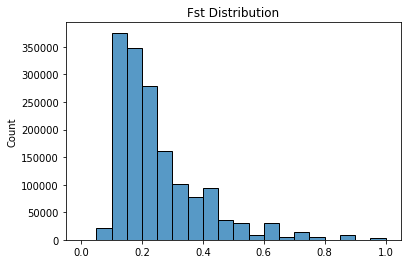

In [4]:
sns.histplot(X_train[:, :, 0].reshape(-1), binwidth=0.05)
plt.title("Fst Distribution")
plt.show()

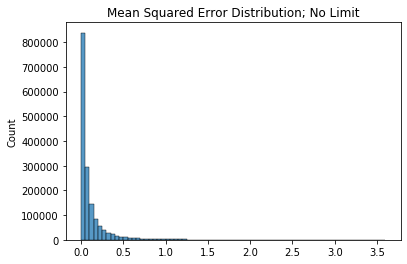

In [5]:
sns.histplot(X_train[:, :, 1].reshape(-1), binwidth=0.05)
plt.title("Mean Squared Error Distribution; No Limit")
plt.show()

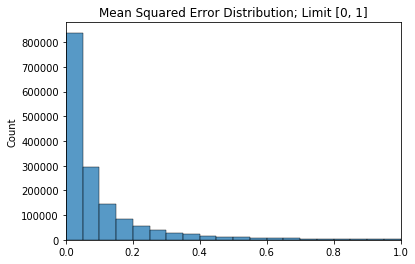

In [6]:
sns.histplot(X_train[:, :, 1].reshape(-1), binwidth=0.05)
plt.title("Mean Squared Error Distribution; Limit [0, 1]")
plt.xlim([0, 1])
plt.show()

In [7]:
# ~ 1% of metrics have MSE >= 1, 
print(sum(X_train[:, :, 1].reshape(-1) >= 1))

# ~3% of metrics have MSE >= 0.6
print(sum(X_train[:, :, 1].reshape(-1) >= 0.6))

# ~6% of metrics have MSE >= 0.4
print(sum(X_train[:, :, 1].reshape(-1) >= 0.4))

15905
49943
98852


In [8]:
"""
Based on the plots, let's make 5 bins each for Fst and MSE, namely:
        1           2           3           4           5
Fst: [0, 0.2), [0.2, 0.4), [0.4, 0.6), [0.6, 0.8), [0.8, 1.0+0.1)
MSE: [0, 0.1), [0,1, 0.2), [0,2, 0.3), [0.3, 0.4), [0.4, max+0.1)

This way, we abstract away the 'location' dimension as a factor
"""
Fst_bins = list(i / 100 for i in range(0, 100, 5))
# Fst_bins = [0, 0.4]
Fst_bins.append(np.amax(X_train[:, :, 0]) + 0.01)
print("Fst bins", Fst_bins)
MSE_bins = list(i / 10 for i in range(0, 5, 1))
# MSE_bins = [0, 0.4]
MSE_bins.append(np.amax(X_train[:, :, 1]) + 0.01)
print("MSE bins", MSE_bins)

def makeLabels(iterable):
    # takes an iterable of bin (start, stop) and make labels
    return ["-".join([str(start), str(round(stop, 2))]) for start, stop in zip(iterable, iterable[1:]) ] 
Fst_labels = makeLabels(Fst_bins)
MSE_labels = makeLabels(MSE_bins)

print("Fst labels", Fst_labels)
print("MSE labels", MSE_labels)

def assignBins(Fst_bins, MSE_bins, X_train, X_test):
    Fst_assignments = np.digitize(X_train[:, :, 0], Fst_bins)
    Fst_bins_count = len(Fst_bins)

    MSE_assignments = np.digitize(X_train[:, :, 1], MSE_bins)
    MSE_bins_count = len(MSE_bins)

    # rows: Fst bin #, cols: MSE bin 
    X_train_bins = np.zeros((Fst_bins_count-1, MSE_bins_count-1), dtype=np.int)
    X_test_bins = np.zeros((Fst_bins_count-1, MSE_bins_count-1), dtype=np.int)
    
    def computeMatrix(base, matrix):
        for i in range(0, len(matrix)):
            sample = matrix[i]
            rows = sample.shape[0]

            # transform this (160, 2) matrix into a fxm bin matrix
            empty = np.zeros((Fst_bins_count-1, MSE_bins_count-1), dtype=np.int)
            for j in range(0, rows):
                Fst_bin = Fst_assignments[i, j]
                MSE_bin = MSE_assignments[i, j]
                empty[Fst_bin-1, MSE_bin-1] += 1
            base = np.concatenate((base, empty))

        base = base.reshape(-1, Fst_bins_count-1, MSE_bins_count-1)
        # drop the first entry (only used for appending)
        base = base[1:, :, :]

        return base
    
    X_train_bins = computeMatrix(X_train_bins, X_train)
    X_test_bins = computeMatrix(X_test_bins, X_test)

    return X_train_bins, X_test_bins

X_train_bins, X_test_bins = assignBins(Fst_bins, MSE_bins, X_train, X_test)
print(X_train_bins.shape)
print(X_test_bins.shape)

Fst bins [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.01]
MSE bins [0.0, 0.1, 0.2, 0.3, 0.4, 3.59904047525725]
Fst labels ['0.0-0.05', '0.05-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '0.35-0.4', '0.4-0.45', '0.45-0.5', '0.5-0.55', '0.55-0.6', '0.6-0.65', '0.65-0.7', '0.7-0.75', '0.75-0.8', '0.8-0.85', '0.85-0.9', '0.9-0.95', '0.95-1.01']
MSE labels ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-3.6']
(10000, 20, 5)
(1000, 20, 5)


In [9]:
def generateHeatmaps(matrices, Fst_labels, MSE_labels, SAS_labels, savePath):
    for i in range(0, matrices.shape[0]):
        ax = sns.heatmap(
            pd.DataFrame(
                matrices[i, :, :], 
                index=Fst_labels, 
                columns=MSE_labels
            ), 
        linewidths=.5)
        # invert y axis to sort Fst ascending
        ax.invert_yaxis()
        figure = plt.gcf()
        figure.set_size_inches(16, 12)
        plt.title("Output " + str(i+1) + " - " + SAS_labels[i] + " SNS")
        plt.ylabel("Fst")
        plt.xlabel("MSE")

        # save plot
        saveFile = os.path.join(savePath, "output"+str(i+1)+".png")
        plt.savefig(saveFile)
        plt.close() # do NOT show in-line

generateHeatmaps(
    # just do the first 10 to save some time
    X_train_bins[:10], 
    Fst_labels, MSE_labels, y_train, savePath="./Images")

In [10]:
y_train = y_train.reshape(y_train.shape[0], )
y_test = y_test.reshape(y_test.shape[0], )
X_train_bins = X_train_bins.reshape(X_train_bins.shape[0], -1)
X_test_bins = X_test_bins.reshape(X_test.shape[0], -1)

print("After flattening:")
print(X_train_bins.shape)
print(y_train.shape)
print(X_test_bins.shape)
print(y_test.shape)

After flattening:
(10000, 100)
(10000,)
(1000, 100)
(1000,)


In [11]:
# Prepare for K fold cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

k = 10
# again, random_state for sake of reproducibility
kf = KFold(n_splits=k, random_state = 42, shuffle=True)

# default confusion matrix 
# we can calculate TP, FP, FN, TN from this matrix at the end
matrix = pd.DataFrame(0, index=['True Yes', 'True No', ''], 
                      columns=['Pred Yes', 'Pred No', ''])

start = time.time()
for train_index, test_index in kf.split(X_train_bins):
    # identify the train and test set within each fold
    X_fold_train, X_fold_test = X_train_bins[train_index], X_train_bins[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]
    
    # fit the model on the training set
#     model = RandomForestClassifier(n_estimators=500, oob_score=True, 
#                                min_samples_leaf = 10, max_depth = 3, 
#                                min_samples_split = 100, max_leaf_nodes = 50,
#                                max_features = 'sqrt', n_jobs=8)

    model = RandomForestClassifier(n_estimators=500, oob_score=True,
                                   max_features = 'sqrt', n_jobs=8)
    model.fit(X_fold_train, y_fold_train)

    # predict label on validation test set, record results
    y_pred = model.predict(X_fold_test)
    y_prob = model.predict_proba(X_fold_test)[:,1]

    # collect metrics
    m = pd.crosstab(y_pred, y_fold_test, margins=True)
    m.index = ['True Yes', 'True No', '']
    m.columns = ['Pred Yes', 'Pred No', '']
    matrix += m

end = time.time()
print('Time taken:', end - start)
print(matrix)
TP, FN = matrix.iloc[0, 0], matrix.iloc[0, 1]
FP, TN = matrix.iloc[1, 0], matrix.iloc[1, 1]
total = TP + FN + FP + TN
print("Accuracy: \t\t\t\t\t\t\t", (TP + TN) / total)
print("Error Rate: \t\t\t\t\t\t\t", (FN + FP) / total)
recall = TP / (TP + FN)
print("True Positive Rate (TPR) | Sensitivity | Recall | Coverage\t", recall)
print("True Negative Rate (TNR) | Specificity \t\t\t\t", 
      TN / (FP + TN))
print("False Positive Rate (FPR) is \t\t\t\t\t", FP / (FP + TN))
print("False Negative Rate (FNR) is \t\t\t\t\t", FN / (TP + FN))
precision = TP / (TP + FP)
print("Average Precision: \t\t\t\t\t\t", precision)
print("Average Recall: \t\t\t\t\t\t", recall)
print("Average F Measures: \t\t\t\t\t\t", 
      (2*precision*recall) / (precision+recall))

Time taken: 13.930890083312988
          Pred Yes  Pred No       
True Yes      2740     2089   4829
True No       2260     2911   5171
              5000     5000  10000
Accuracy: 							 0.5651
Error Rate: 							 0.4349
True Positive Rate (TPR) | Sensitivity | Recall | Coverage	 0.5674052598881756
True Negative Rate (TNR) | Specificity 				 0.5629472055695224
False Positive Rate (FPR) is 					 0.4370527944304777
False Negative Rate (FNR) is 					 0.4325947401118244
Average Precision: 						 0.548
Average Recall: 						 0.5674052598881756
Average F Measures: 						 0.557533828466782


Time taken: 1.4501984119415283
Feature Fst 0.0-0.05; MSE 0.0-0.1 importance: 5.6529528361442624e-05 						
Feature Fst 0.0-0.05; MSE 0.1-0.2 importance: 0.0 						
Feature Fst 0.0-0.05; MSE 0.2-0.3 importance: 0.0 						
Feature Fst 0.0-0.05; MSE 0.3-0.4 importance: 0.0 						
Feature Fst 0.0-0.05; MSE 0.4-3.6 importance: 0.0 						
Feature Fst 0.05-0.1; MSE 0.0-0.1 importance: 0.038965607250915565 						
Feature Fst 0.05-0.1; MSE 0.1-0.2 importance: 5.16413219930819e-05 						
Feature Fst 0.05-0.1; MSE 0.2-0.3 importance: 6.658509726375368e-06 						
Feature Fst 0.05-0.1; MSE 0.3-0.4 importance: 0.0 						
Feature Fst 0.05-0.1; MSE 0.4-3.6 importance: 0.0 						
Feature Fst 0.1-0.15; MSE 0.0-0.1 importance: 0.06989721072270899 						
Feature Fst 0.1-0.15; MSE 0.1-0.2 importance: 4.3716218940199974e-05 						
Feature Fst 0.1-0.15; MSE 0.2-0.3 importance: 4.431587265636601e-06 						
Feature Fst 0.1-0.15; MSE 0.3-0.4 importance: 0.0 						
Feature Fst 0.1-0.15; MSE 0.4-3.6 importance: 0

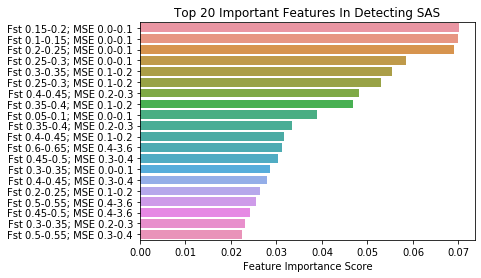

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# n_estimators = number of trees to bag
# Fit the model on all training samples possible
# clf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, 
#                         min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                         max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                         min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
#                         random_state=None, verbose=0, warm_start=False, class_weight=None, 
#                         ccp_alpha=0.0, max_samples=None)
# Tune: min_samples_split, max_leaf_nodes, max_depth and min_samples_leaf.
model = RandomForestClassifier(n_estimators=500, oob_score=True,
                               max_features = 'sqrt', n_jobs=8)
# model = RandomForestClassifier(n_estimators=500, oob_score=True, 
#                                min_samples_leaf = 10, max_depth = 5, 
#                                min_samples_split = 100, max_leaf_nodes = 50,
#                                max_features = 'sqrt', n_jobs=8)
start = time.time()
model.fit(X_train_bins, y_train)
end = time.time()
print('Time taken:', end - start)

# save the model
# joblib.dump(model, "./data/random_forest_10000.joblib")

from itertools import product
feature_labels = [ 
    "Fst " + i + "; MSE " + j for i, j in product(Fst_labels, MSE_labels) 
]

for f, imp in zip(feature_labels, model.feature_importances_):
    print(f'Feature {f} importance: {imp} \t\t\t\t\t\t')

# take the top 20 most important features
feature_imp = pd.Series(
    model.feature_importances_, index=feature_labels
).sort_values(ascending=False)[:20]

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Top 20 Important Features In Detecting SAS")
plt.show()


In [13]:
# Extract single tree
estimator = model.estimators_[203]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_labels,
                class_names = ["SAS", "Neutral"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
display(Image(filename = 'tree.png'))

In [14]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import MinMaxScaler

# param_grid = {
#     'max_depth':list(range(35,55+1)),
#     'min_samples_leaf':list(range(8,35,2)),
#     'max_features':['sqrt', 'log2'],
# }

# clf = GridSearchCV(RandomForestClassifier(criterion='gini'), param_grid, 
#                    scoring="accuracy", cv=5, n_jobs=8)
# clf.fit(X_train_bins, y_train)
# print(clf.best_params_)

# rf_pred = cross_val_predict(
#     RandomForestClassifier(criterion='gini'), 
#     X=X_train_bins, y=y_train, cv=5, n_jobs=12)
# print("The average nested cross validation accuracy is ", accuracy_score(y_train, rf_pred))

# print(confusion_matrix(y_train, rf_pred))

# print(classification_report(y_train, rf_pred))

## Test Set Evaluation

Below are peformance measures on the test set never touched during model building

In [15]:
y_pred = model.predict(X_test_bins)
print("Accuracy on Test Set:", accuracy_score(y_test,y_pred))
print(f'Our OOB prediction of accuracy is: {model.oob_score_ * 100}%')

# show stats
matrix = pd.crosstab(y_pred, y_test, margins=True)
matrix.index = ['True Yes', 'True No', '']
matrix.columns = ['Pred Yes', 'Pred No', '']
print(matrix)

TP, FN = matrix.iloc[0, 0], matrix.iloc[0, 1]
FP, TN = matrix.iloc[1, 0], matrix.iloc[1, 1]
total = TP + FN + FP + TN
print("Accuracy: \t\t\t\t\t\t\t", (TP + TN) / total)
print("Error Rate: \t\t\t\t\t\t\t", (FN + FP) / total)
print("True Positive Rate (TPR) | Sensitivity | Recall | Coverage\t", 
      TP / (TP + FN))
print("True Negative Rate (TNR) | Specificity \t\t\t\t", 
      TN / (FP + TN))
print("False Positive Rate (FPR) is \t\t\t\t\t", FP / (FP + TN))
print("False Negative Rate (FNR) is \t\t\t\t\t", FN / (TP + FN))
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print("Average Precision: \t\t\t\t\t\t", precision)
print("Average F Measures: \t\t\t\t\t\t", 
      (2*recall*precision) / (recall + precision))
pred_prob = model.predict_proba(X_test_bins)[:, 1]
print("Average AUC: \t\t\t\t\t\t\t", roc_auc_score(y_test, pred_prob))

Accuracy on Test Set: 0.489
Our OOB prediction of accuracy is: 56.8%
          Pred Yes  Pred No      
True Yes       238      249   487
True No        262      251   513
               500      500  1000
Accuracy: 							 0.489
Error Rate: 							 0.511
True Positive Rate (TPR) | Sensitivity | Recall | Coverage	 0.4887063655030801
True Negative Rate (TNR) | Specificity 				 0.48927875243664715
False Positive Rate (FPR) is 					 0.5107212475633528
False Negative Rate (FNR) is 					 0.5112936344969199
Average Precision: 						 0.476
Average F Measures: 						 0.4822695035460993
Average AUC: 							 0.5153840000000001


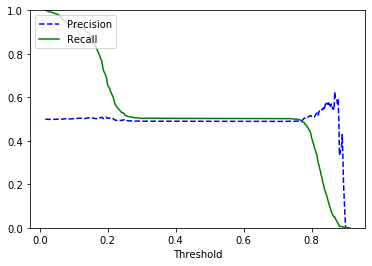

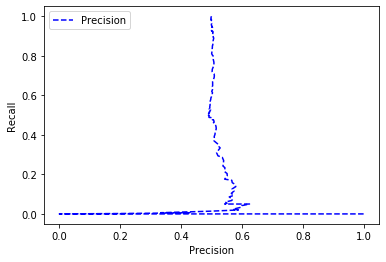

In [16]:
from sklearn.metrics import precision_recall_curve

# precision recall curve for training set 
y_prob = model.predict_proba(X_test_bins)[:,1]
precisions, recalls, thresholds = precision_recall_curve(
    y_test, y_prob, pos_label = "Yes")

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plt.plot(precisions, recalls, "b--", label="Precision")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="upper left")
plt.show()

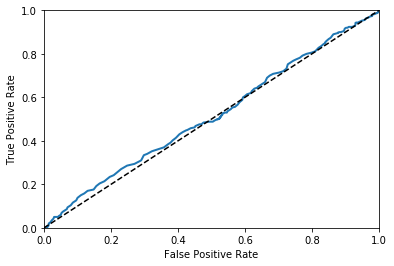

The AUC is  0.5153840000000001


In [17]:
# ROC Curve
# The more the area under the curve the better our classifier
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label = "Yes")
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr, "Random Forest")
plt.show()

from sklearn.metrics import roc_auc_score
print("The AUC is ", roc_auc_score(y_test, y_prob))

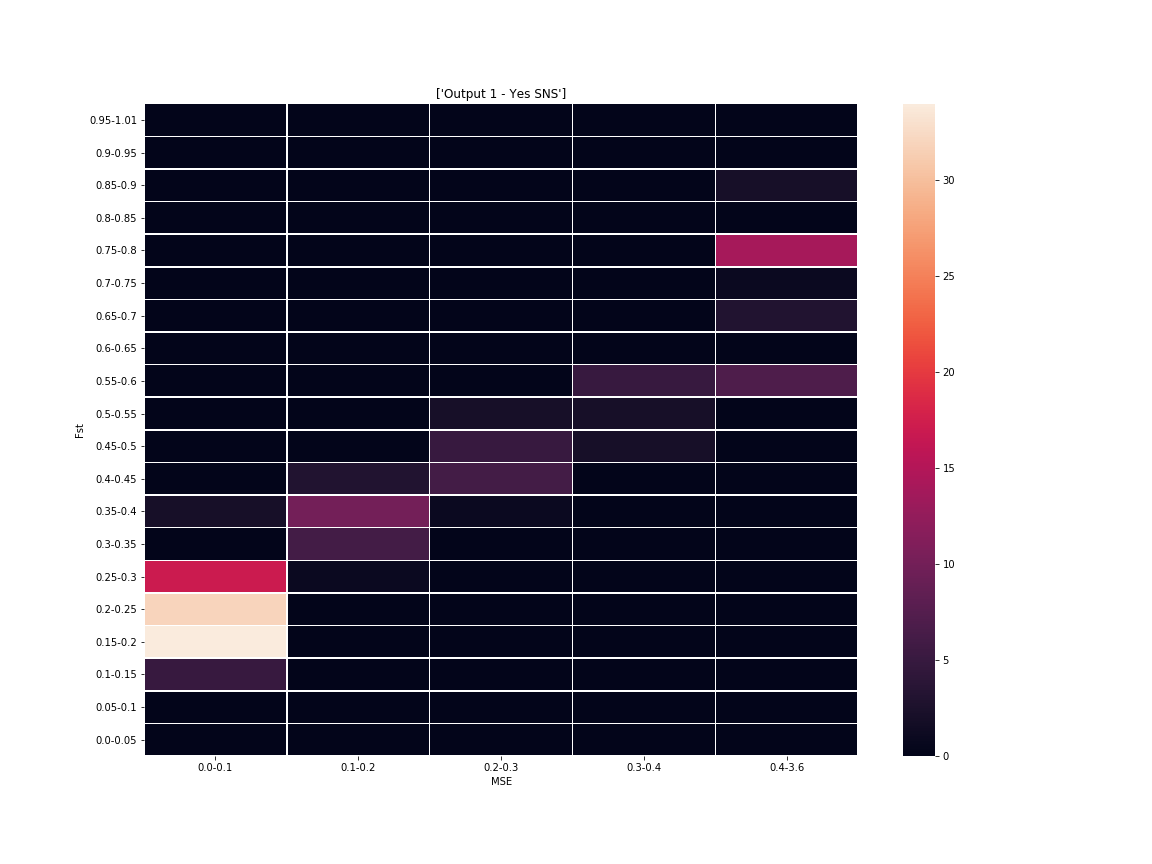

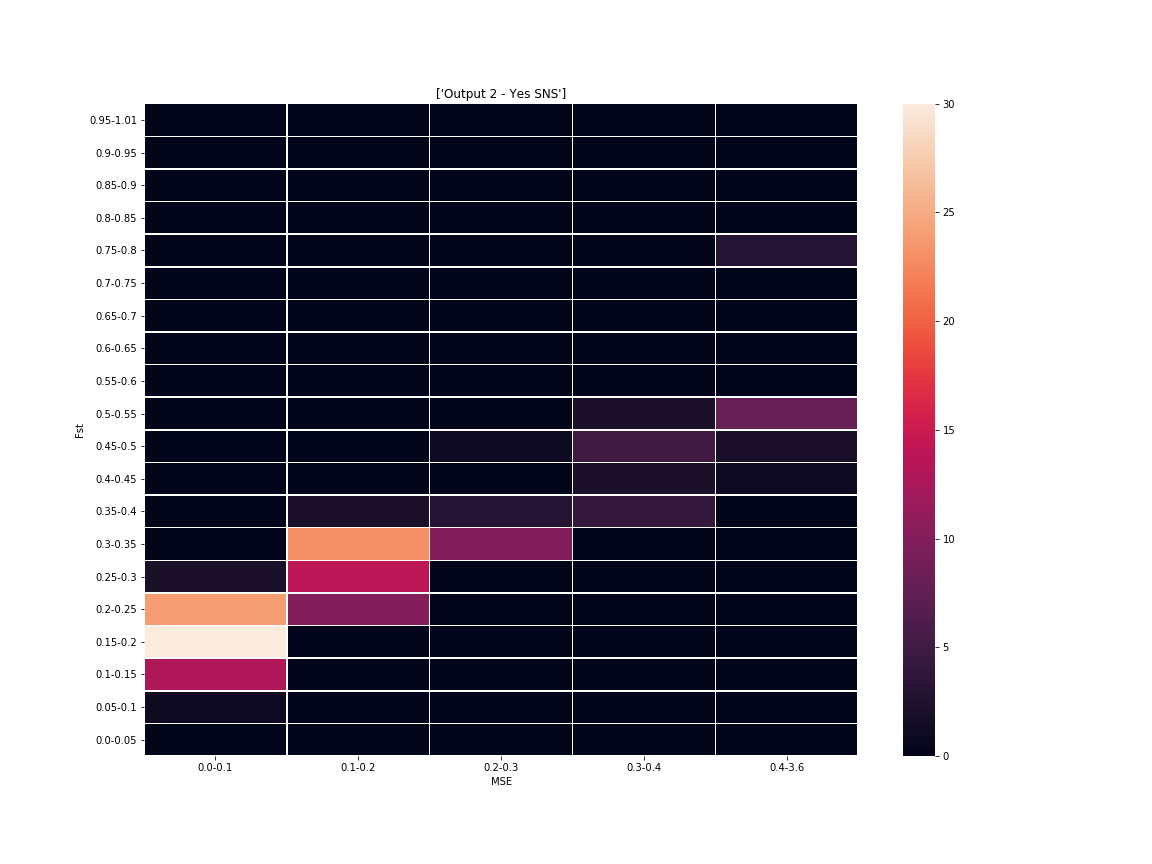

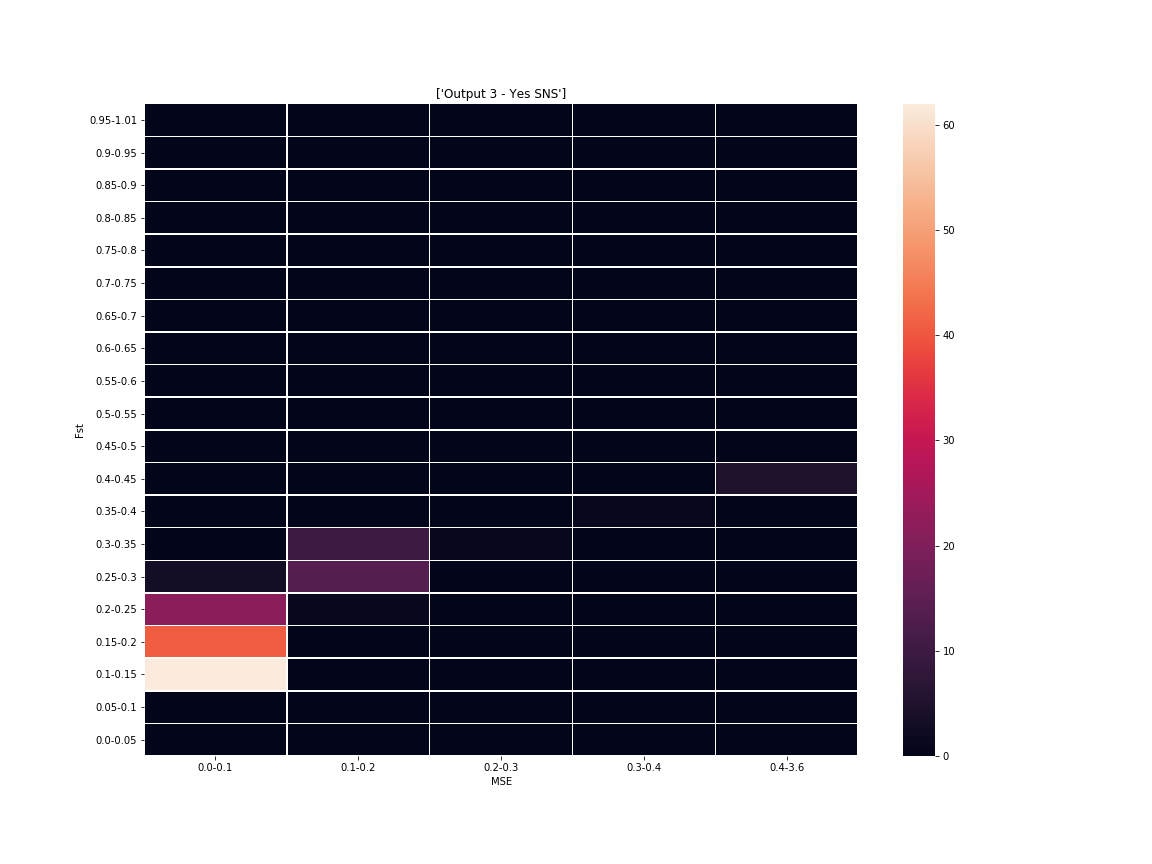

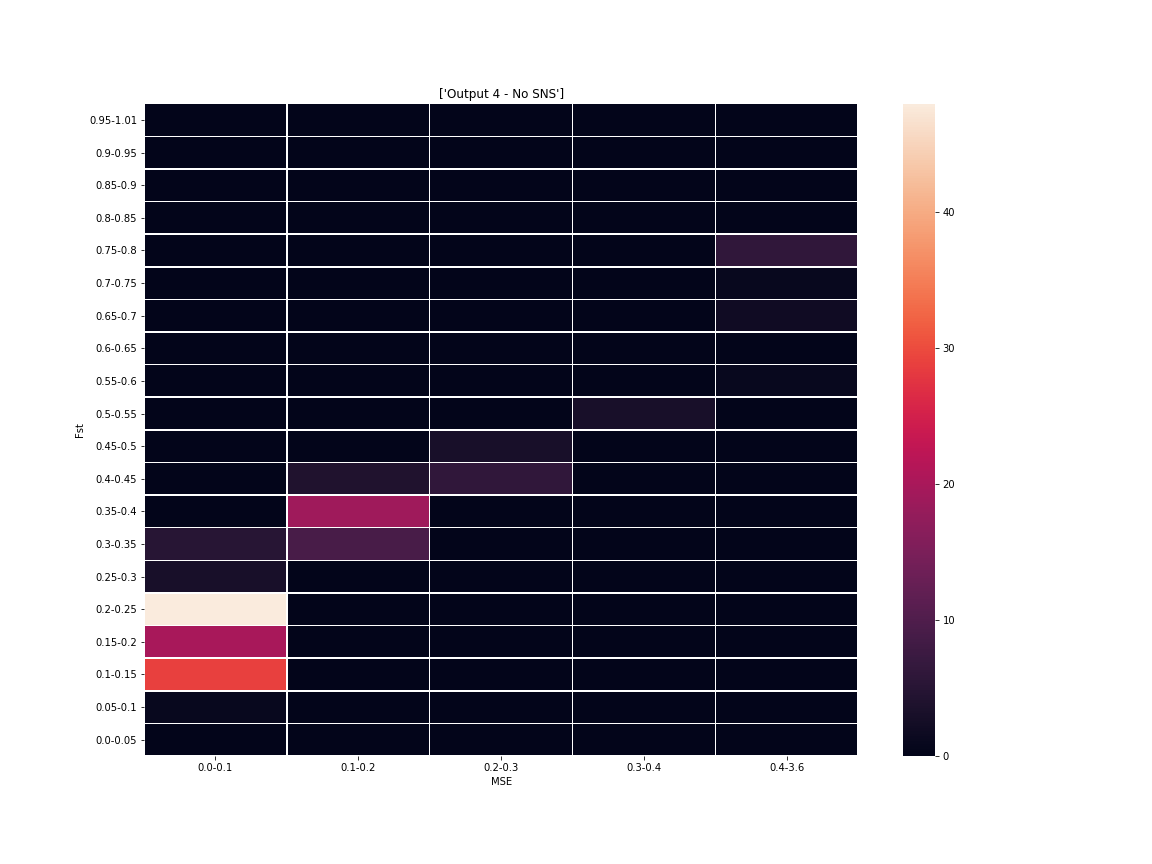

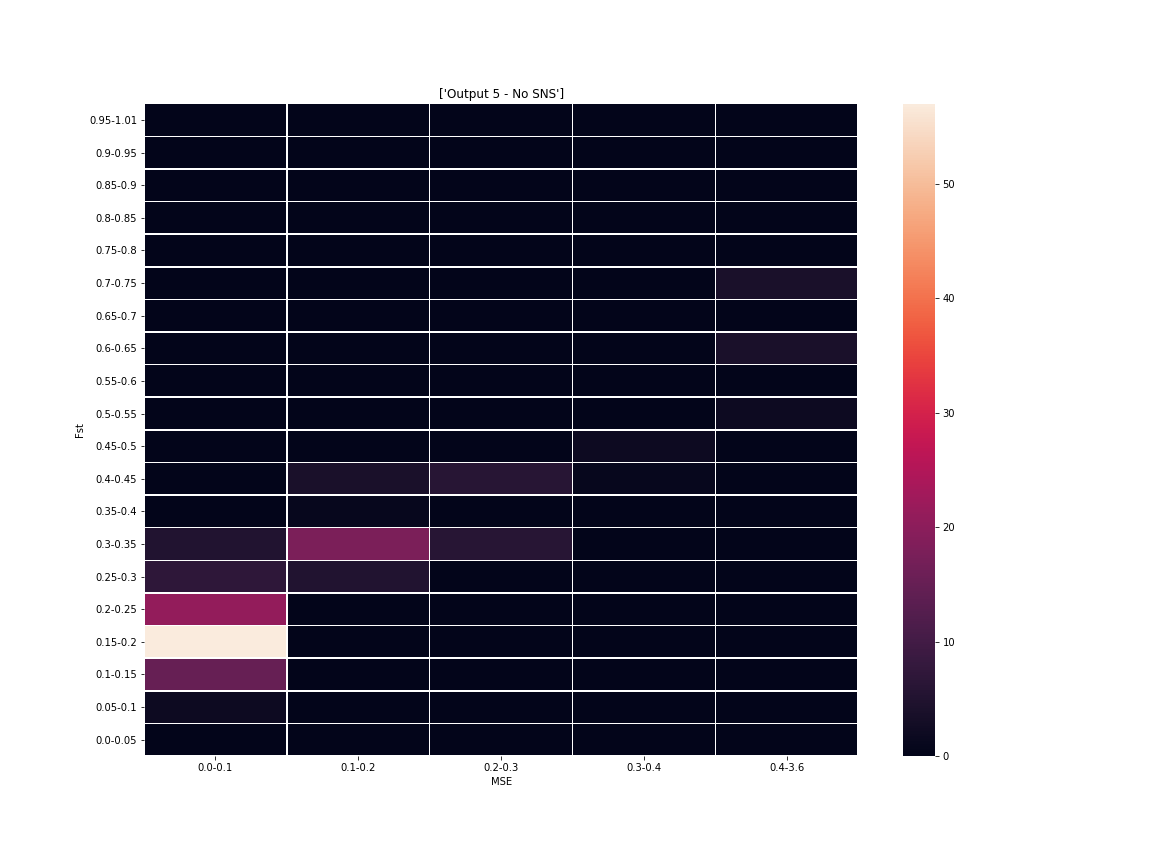

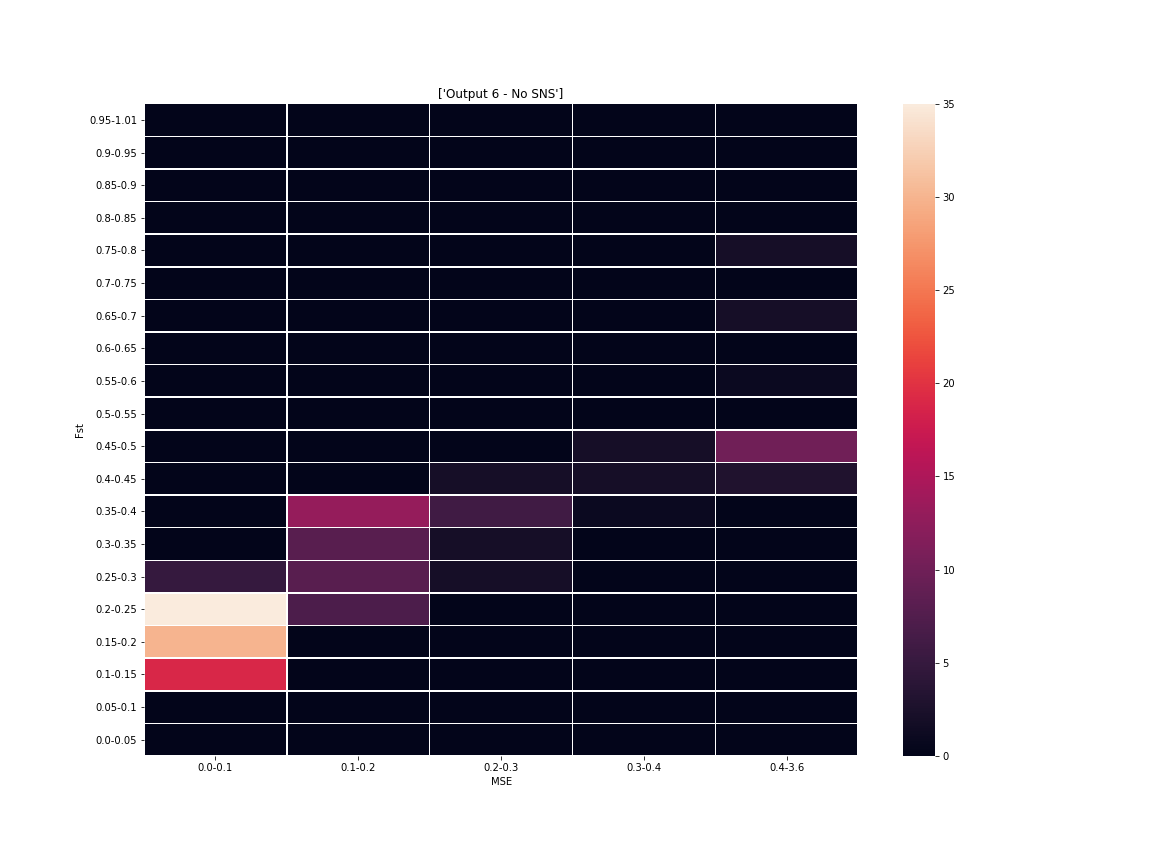

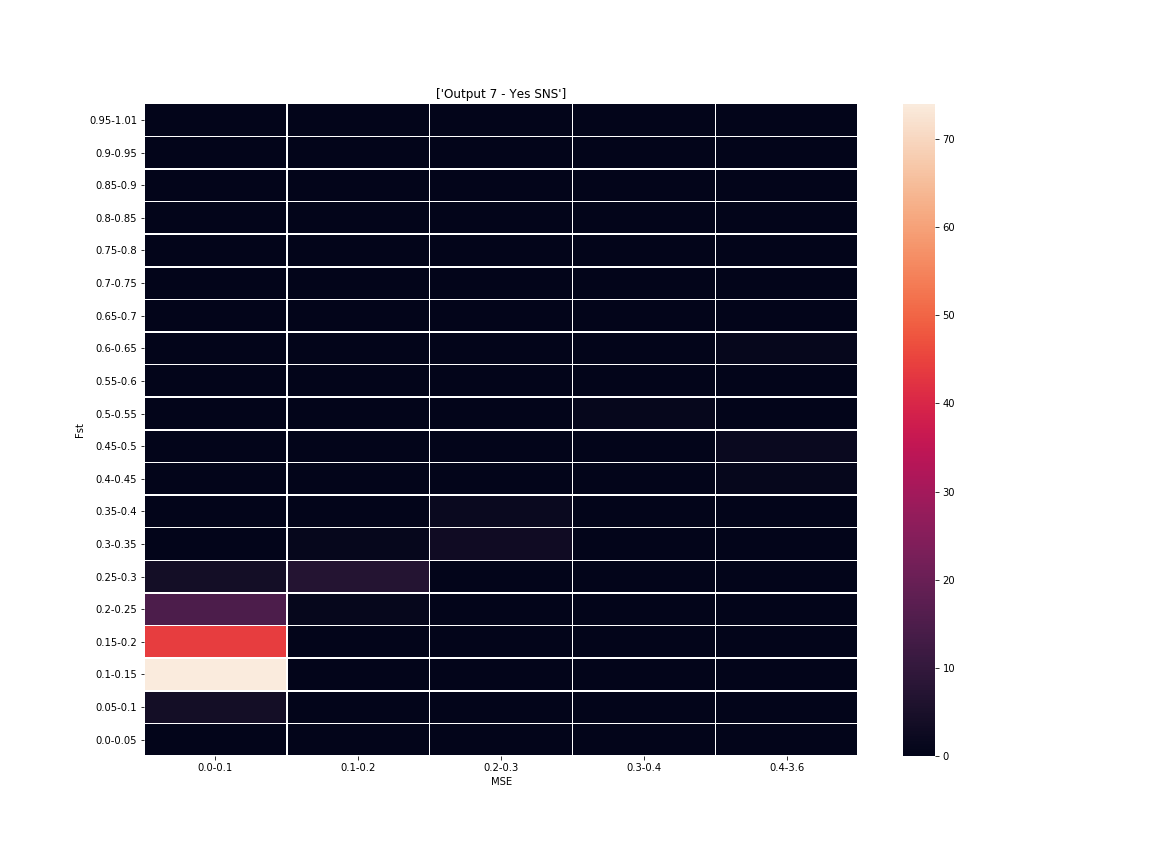

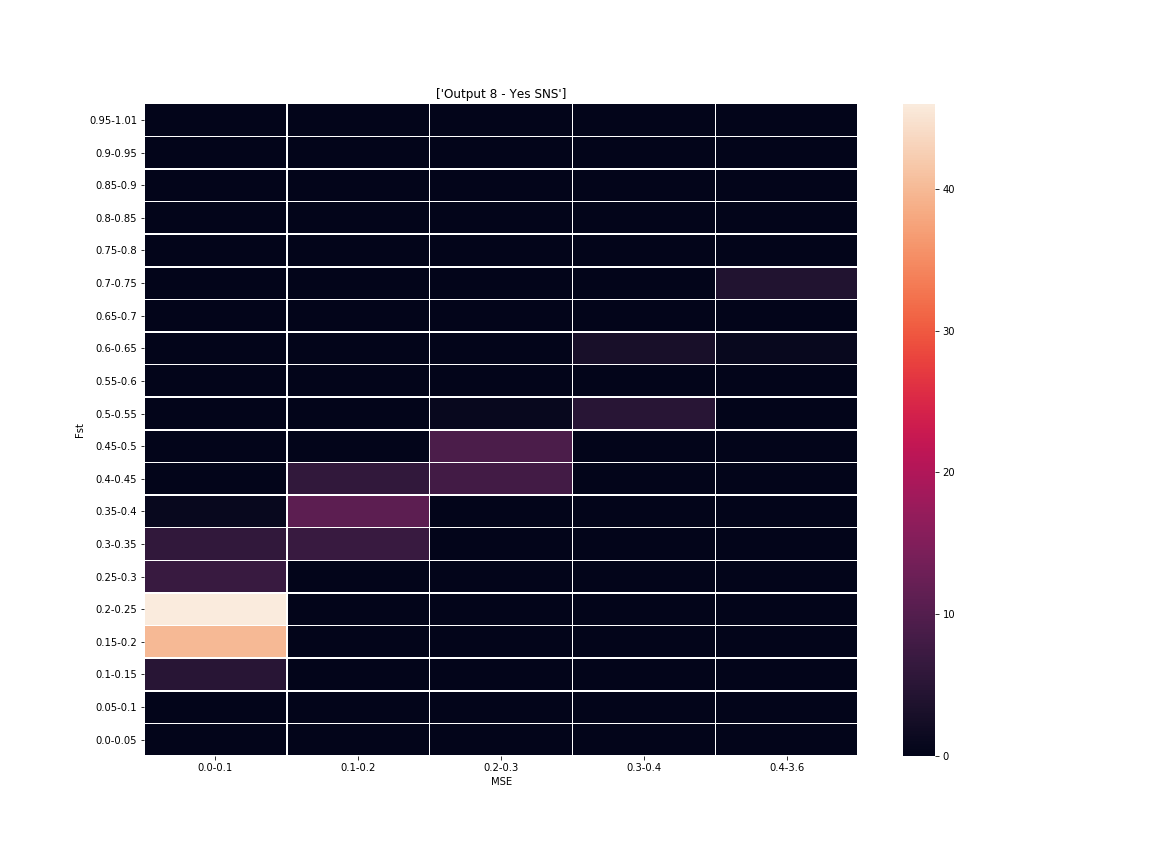

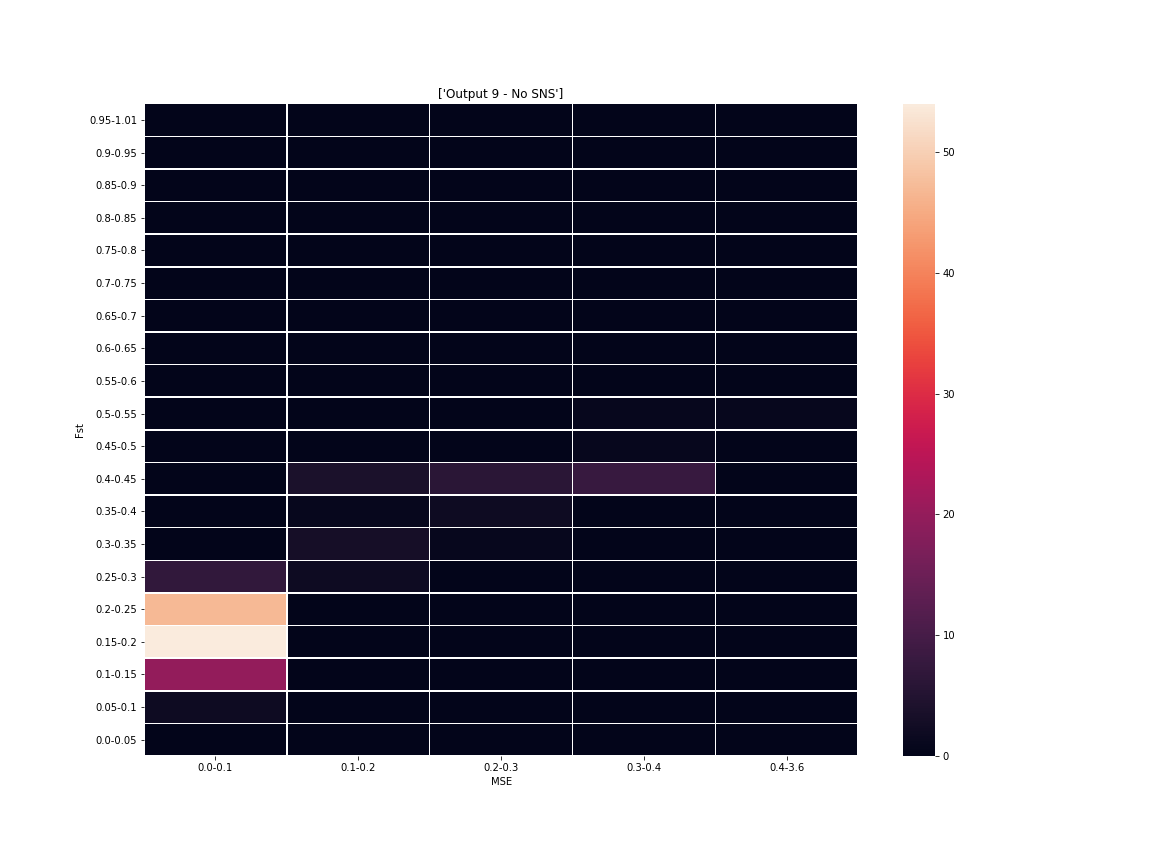

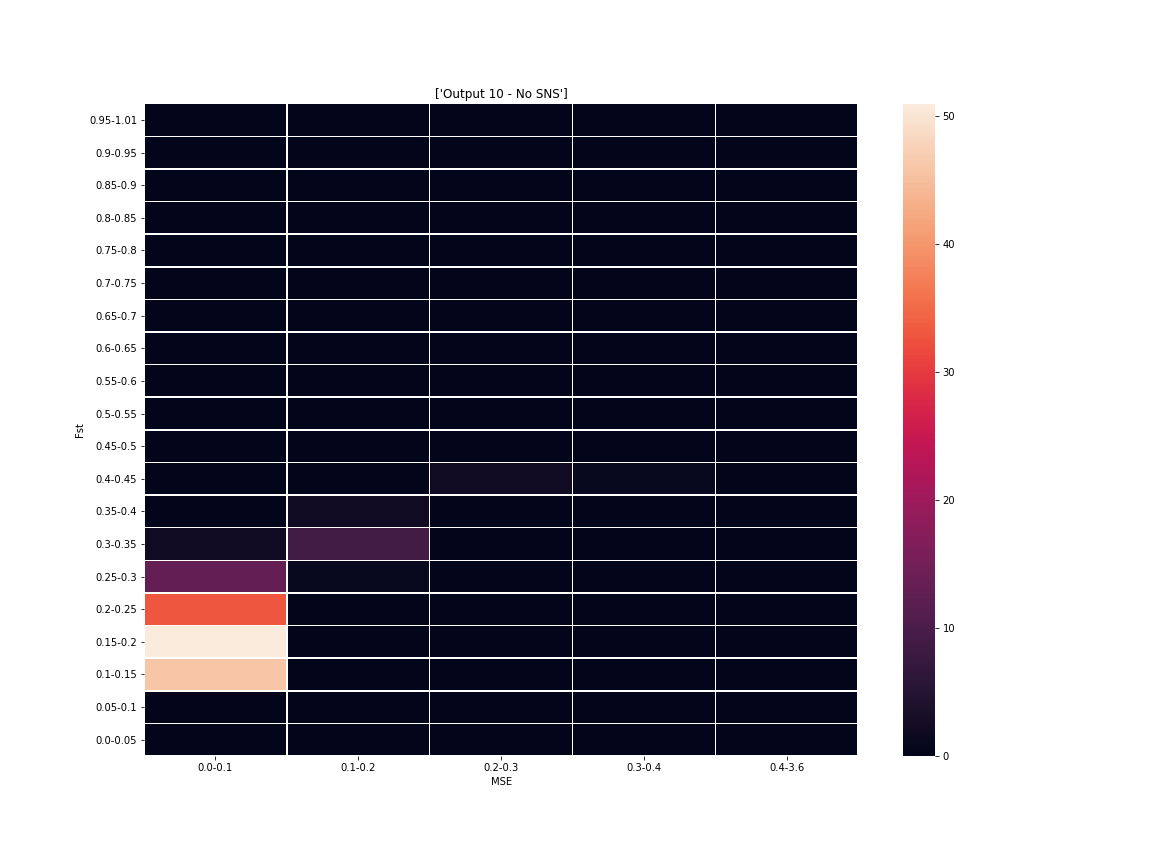

In [18]:
from IPython.display import Image
for i in range(1, 11):
    path = "./Images/output" + str(i) + ".png"
    display(Image(filename=path))

# Issues

Can try a variety of bin values, but all results in low cross validated and test accuracy...

Reason: assumption that SAS samples will have 'same regions that light up' not exactly true;

From the heatmaps above, SAS samples do NOT seem much different compared to Non-SAS samples